# ***Import Libraries:***

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# ***Preparing Some Functions And Classes To Use :***

### *A method to Extract Frames From Videos*

In [2]:
def extractFrames(videoPath, frameCount=8):
    cap = cv2.VideoCapture(videoPath)
    frames = []
    totalFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for i in np.linspace(0, totalFrames - 1, frameCount).astype(int):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        success, frame = cap.read()
        if success:
            frame = cv2.resize(frame, (180, 180))
            frames.append(frame)
    cap.release()
    return frames

# *Load The Dataset :*

In [3]:
# Set dataset path
datasetPath = "/kaggle/input/theft-detection-dataset/Shop DataSet"
nonLiftersPath = os.path.join(datasetPath, "non shop lifters")
liftersPath = os.path.join(datasetPath, "shop lifters")

# Load dataset
data, labels = [], []
for label, folder in enumerate([nonLiftersPath, liftersPath]):
    for file in tqdm(os.listdir(folder), desc=f"Processing {folder}"):
        if file.endswith(".mp4"):
            frames = extractFrames(os.path.join(folder, file))
            for frame in frames:
                data.append(frame)
                labels.append(label)

Processing /kaggle/input/theft-detection-dataset/Shop DataSet/non shop lifters: 100%|██████████| 531/531 [01:47<00:00,  4.92it/s]
Processing /kaggle/input/theft-detection-dataset/Shop DataSet/shop lifters: 100%|██████████| 324/324 [02:08<00:00,  2.52it/s]


# ***Applying Preprocessing And Data Augmentation :***

In [4]:
# Convert to NumPy Arrays & Normalize
data = np.array(data, dtype="float32") / 255.0  # Normalize
labels = np.array(labels)

# Train-Test-Validation Split
trainData, tempData, trainLabels, tempLabels = train_test_split(data, labels, test_size=0.3, random_state=42, stratify=labels)
valData, testData, valLabels, testLabels = train_test_split(tempData, tempLabels, test_size=0.5, random_state=42, stratify=tempLabels)

# Data Augmentation
dataGen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode="nearest"
)

# ***Train And Fine Tune Model :***

In [5]:
# Load Pretrained Model (Fine-tuned)
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(180, 180, 3))
baseModel.trainable = True  # Freeze initial layers

# Build the Model
x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)  # Improve training stability
x = Dropout(0.3)(x)  # Increase dropout for regularization
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=baseModel.input, outputs=outputs)

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
earlyStopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train Model
history = model.fit(dataGen.flow(trainData, trainLabels, batch_size=16),
                    validation_data=(valData, valLabels),
                    epochs=100,
                    callbacks=[earlyStopping, lr_scheduler])

# Save Model
model.save("shopLiftingDetector.h5")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 100s 187ms/step - accuracy: 0.5934 - loss: 0.7905 - val_accuracy: 0.6257 - val_loss: 0.7223 - learning_rate: 1.0050e-04
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - accuracy: 0.7331 - loss: 0.5603 - val_accuracy: 0.7339 - val_loss: 0.4836 - learning_rate: 1.0050e-04
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.8340 - loss: 0.3879 - val_accuracy: 0.6881 - val_loss: 0.6754 - learning_rate: 1.0050e-04
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - accuracy: 0.8741 - loss: 0.2971 - val_accuracy: 0.5400 - val_loss: 1.7478 - learning_rate: 1.0050e-04
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - accuracy: 0.9109 - loss: 0.2265 - val_accuracy: 0.5146 - val_loss: 2.2901 - learning_rate: 1.0050e-04
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 32s 104ms/step - accuracy: 0.9223 - loss: 0.1898 - val_accuracy: 0.5916 - val_loss: 1.2046 - learning_rate: 5

# ***Visualizating Model Performance :***

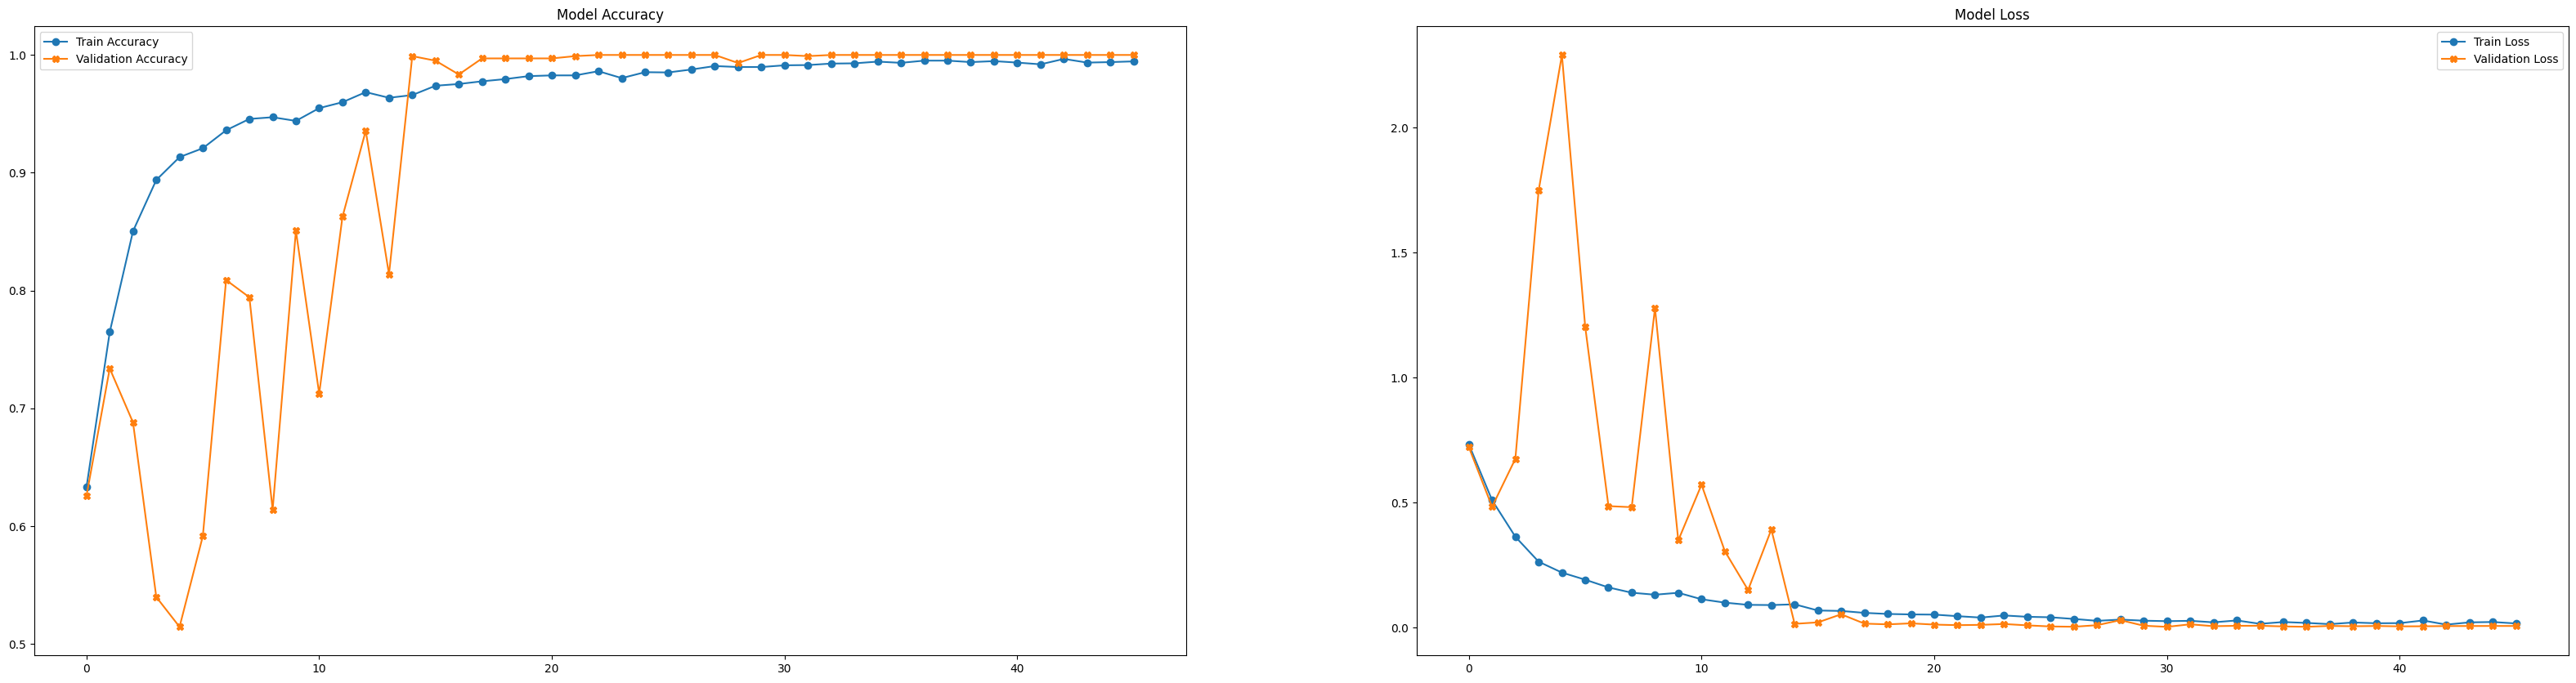

In [6]:
# Plot Training Performance
plt.figure(figsize=(40,10))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy',marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='X')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss',marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='X')
plt.legend()
plt.title('Model Loss')
plt.show()

# ***Visualize The Predictions :***

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


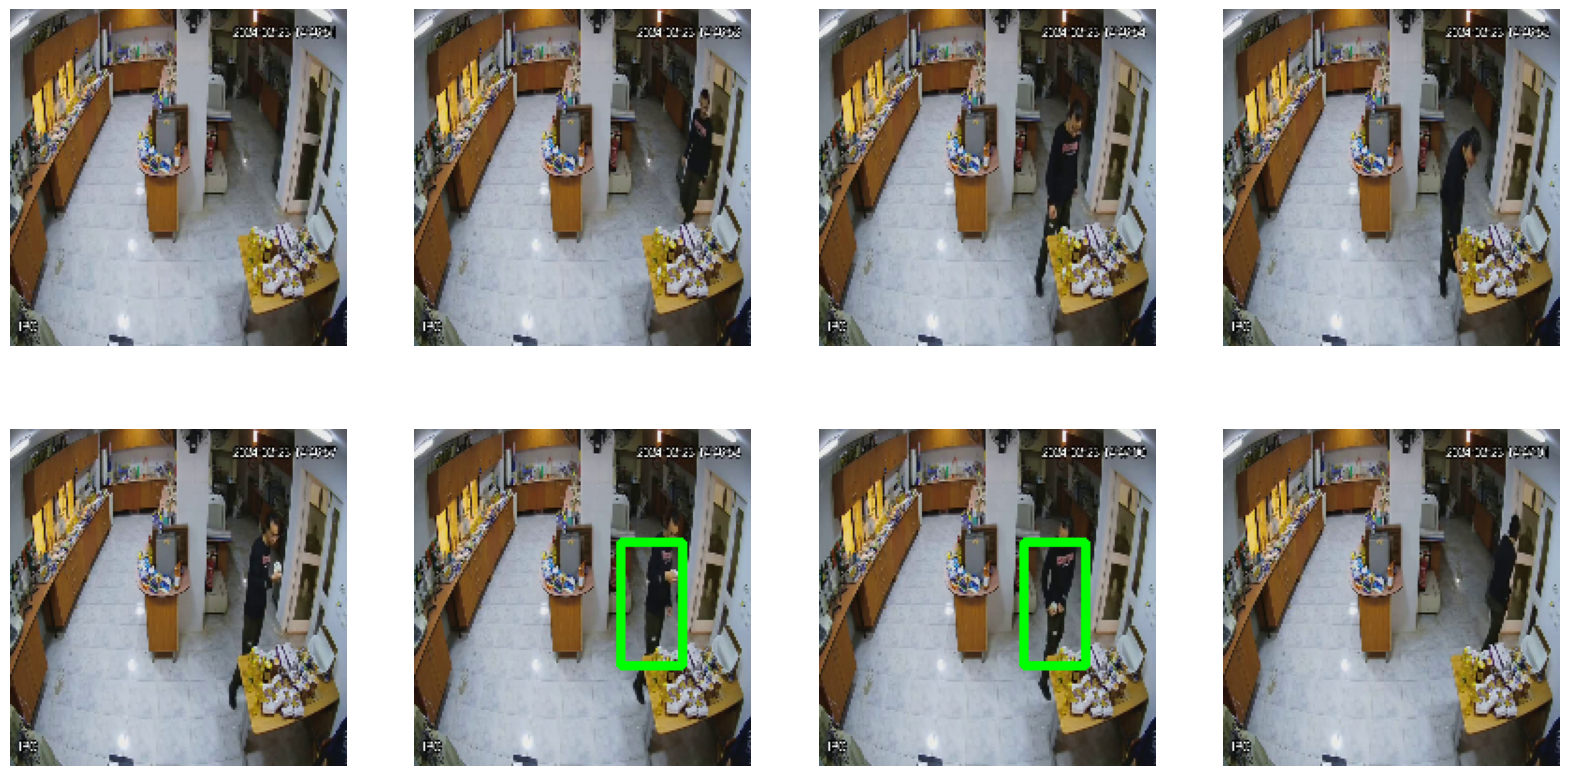

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model("/kaggle/working/shopLiftingDetector.h5")

# Function to extract frames from videos
def extractFrames(videoPath, frameCount=8):
    cap = cv2.VideoCapture(videoPath)
    frames = []
    totalFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for i in np.linspace(0, totalFrames - 1, frameCount).astype(int):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        success, frame = cap.read()
        if success:
            frame = cv2.resize(frame, (180, 180))  # Resize to match model input
            frames.append(frame)
    cap.release()
    return frames

# Make Predictions and Visualize
def plotPrediction(videoPath):
    frames = extractFrames(videoPath)
    predictions = model.predict(np.array(frames) / 255.0)
    personCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_fullbody.xml")
    tracker = None
    initBB = None
    
    plt.figure(figsize=(20, 10))
    for i, frame in enumerate(frames):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        
        if initBB is None:
            persons = personCascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=5, minSize=(30, 30))
            if len(persons) > 0:
                x, y, w, h = persons[0]
                initBB = (x, y, w, h)
                tracker = cv2.TrackerKCF_create()
                tracker.init(frame, initBB)
        
        if tracker is not None:
            success, box = tracker.update(frame)
            if success:
                x, y, w, h = [int(v) for v in box]
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)  # Green rectangle around detected person
        
        plt.subplot(2, 4, i + 1)
        plt.imshow(frame)
        plt.axis('off')
    plt.show()

# Example Usage
sampleVideo = os.path.join(liftersPath, os.listdir(liftersPath)[0])
plotPrediction(sampleVideo)